In [2]:
from argparse import ArgumentParser
import os
import sys
import random
import logging
import numpy as np

from scipy import integrate
from sklearn.metrics import mean_squared_error as MSE
import copy

from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate

import torch
from torch.utils.data import DataLoader

In [3]:
from IPython.display import SVG, display
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

In [4]:
%cd drive/MyDrive/deep-stpp/notebooks

/content/drive/MyDrive/deep-stpp/notebooks


In [5]:
sys.path.append("/content/drive/MyDrive/deep-stpp/src")
from plotter import *
from model import DeepSTPP, log_ft, t_intensity, s_intensity
from data.dataset import SlidingWindowWrapper
from data.synthetic import *
from util import *

In [6]:
"""The code below is used to set up customized training device on computer"""
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("You are using GPU acceleration.")
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("CUDA is not Available. You are using CPU only.")
    print("Number of cores: ", os.cpu_count())

CUDA is not Available. You are using CPU only.
Number of cores:  2


In [7]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0003, momentum=0.9, epochs=50, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-3, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='sigmoid', sample=True, decoder_n_layer=3)

In [8]:
"""
Prepare logger
"""
logger = logging.getLogger('full_lookahead{}batch{}'.format(config.lookahead, config.batch))
logger.setLevel(logging.DEBUG)
hdlr = logging.FileHandler('full_lookahead{}batch{}.log'.format(config.lookahead, config.batch))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

## COVID NJ cases

In [ ]:
dataset = 'covid_nj_cases'
npzf = np.load(f'../data/processed/{dataset}.npz', allow_pickle=True)

In [ ]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)
valset   = SlidingWindowWrapper(npzf['val'],   normalized=True, min=trainset.min, max=trainset.max)
testset  = SlidingWindowWrapper(npzf['test'],  normalized=True, min=trainset.min, max=trainset.max)

In [ ]:
train_loader = DataLoader(trainset, batch_size=config.batch, shuffle=True)
val_loader   = DataLoader(valset,   batch_size=config.batch, shuffle=False)
test_loader  = DataLoader(testset,  batch_size=config.batch, shuffle=False)

In [ ]:
from model import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/{dataset}_0.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:14:23,361 INFO In epochs 0 | total loss: 0.252244 | Space: 0.974664 | Time: 3.615590


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:14:47,228 INFO In epochs 1 | total loss: 0.123855 | Space: 1.123310 | Time: 3.645695


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:15:10,968 INFO In epochs 2 | total loss: 0.081029 | Space: 1.173969 | Time: 3.656585


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:15:34,756 INFO In epochs 3 | total loss: 0.059609 | Space: 1.200061 | Time: 3.662205


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:15:58,510 INFO In epochs 4 | total loss: 0.046751 | Space: 1.215955 | Time: 3.665671
2021-12-05 12:15:58,703 INFO Val Loss -0.003666 | Space: 1.176269 | Time: 2.706047


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:16:22,679 INFO In epochs 5 | total loss: 0.038176 | Space: 1.226730 | Time: 3.668097


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:16:46,793 INFO In epochs 6 | total loss: 0.032048 | Space: 1.234603 | Time: 3.669805


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:17:11,188 INFO In epochs 7 | total loss: 0.027451 | Space: 1.240443 | Time: 3.671253


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:17:35,441 INFO In epochs 8 | total loss: 0.023874 | Space: 1.245112 | Time: 3.672331


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:18:00,002 INFO In epochs 9 | total loss: 0.021011 | Space: 1.248892 | Time: 3.673221
2021-12-05 12:18:00,200 INFO Val Loss -0.003867 | Space: 1.199274 | Time: 2.691350


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:18:24,442 INFO In epochs 10 | total loss: 0.018668 | Space: 1.252023 | Time: 3.673967


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:18:48,566 INFO In epochs 11 | total loss: 0.016715 | Space: 1.254647 | Time: 3.674596


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:19:12,566 INFO In epochs 12 | total loss: 0.015061 | Space: 1.256920 | Time: 3.675102


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:19:36,999 INFO In epochs 13 | total loss: 0.013643 | Space: 1.258827 | Time: 3.675577


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:20:01,117 INFO In epochs 14 | total loss: 0.012414 | Space: 1.260511 | Time: 3.675982
2021-12-05 12:20:01,289 INFO Val Loss -0.003808 | Space: 1.201356 | Time: 2.701205


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:20:25,600 INFO In epochs 15 | total loss: 0.011338 | Space: 1.262000 | Time: 3.676354


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:20:49,918 INFO In epochs 16 | total loss: 0.010388 | Space: 1.263367 | Time: 3.676666


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:21:14,221 INFO In epochs 17 | total loss: 0.009543 | Space: 1.264556 | Time: 3.676962


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:21:38,348 INFO In epochs 18 | total loss: 0.008788 | Space: 1.265637 | Time: 3.677207


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:22:02,530 INFO In epochs 19 | total loss: 0.008107 | Space: 1.266618 | Time: 3.677431
2021-12-05 12:22:02,712 INFO Val Loss -0.003440 | Space: 1.214001 | Time: 2.713573


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:22:26,905 INFO In epochs 20 | total loss: 0.007491 | Space: 1.267523 | Time: 3.677618


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:22:51,117 INFO In epochs 21 | total loss: 0.006933 | Space: 1.268333 | Time: 3.677812


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:23:15,068 INFO In epochs 22 | total loss: 0.006421 | Space: 1.269069 | Time: 3.677984


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:23:39,288 INFO In epochs 23 | total loss: 0.005953 | Space: 1.269743 | Time: 3.678143


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:24:03,424 INFO In epochs 24 | total loss: 0.005520 | Space: 1.270366 | Time: 3.678296
2021-12-05 12:24:03,595 INFO Val Loss -0.003767 | Space: 1.198934 | Time: 2.699147


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:24:27,988 INFO In epochs 25 | total loss: 0.005122 | Space: 1.270962 | Time: 3.678419


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:24:52,388 INFO In epochs 26 | total loss: 0.004752 | Space: 1.271507 | Time: 3.678545


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:25:17,048 INFO In epochs 27 | total loss: 0.004410 | Space: 1.272021 | Time: 3.678654


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:25:41,465 INFO In epochs 28 | total loss: 0.004090 | Space: 1.272492 | Time: 3.678761


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:26:05,858 INFO In epochs 29 | total loss: 0.003792 | Space: 1.272920 | Time: 3.678865
2021-12-05 12:26:06,038 INFO Val Loss -0.003803 | Space: 1.213141 | Time: 2.709413


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:26:30,171 INFO In epochs 30 | total loss: 0.003513 | Space: 1.273339 | Time: 3.678950


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:26:54,556 INFO In epochs 31 | total loss: 0.003251 | Space: 1.273722 | Time: 3.679041


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:27:18,965 INFO In epochs 32 | total loss: 0.003005 | Space: 1.274091 | Time: 3.679127


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:27:43,488 INFO In epochs 33 | total loss: 0.002773 | Space: 1.274440 | Time: 3.679206


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:28:08,191 INFO In epochs 34 | total loss: 0.002555 | Space: 1.274759 | Time: 3.679280
2021-12-05 12:28:08,361 INFO Val Loss -0.003872 | Space: 1.204758 | Time: 2.699944


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:28:32,899 INFO In epochs 35 | total loss: 0.002349 | Space: 1.275071 | Time: 3.679346


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:28:57,422 INFO In epochs 36 | total loss: 0.002154 | Space: 1.275352 | Time: 3.679415


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:29:22,005 INFO In epochs 37 | total loss: 0.001969 | Space: 1.275627 | Time: 3.679482


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:29:46,550 INFO In epochs 38 | total loss: 0.001793 | Space: 1.275903 | Time: 3.679538


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:30:11,112 INFO In epochs 39 | total loss: 0.001626 | Space: 1.276159 | Time: 3.679598
2021-12-05 12:30:11,286 INFO Val Loss -0.003869 | Space: 1.205576 | Time: 2.692893


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:30:35,791 INFO In epochs 40 | total loss: 0.001468 | Space: 1.276397 | Time: 3.679655


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:31:00,370 INFO In epochs 41 | total loss: 0.001316 | Space: 1.276629 | Time: 3.679700


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:31:24,871 INFO In epochs 42 | total loss: 0.001173 | Space: 1.276855 | Time: 3.679744


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:31:49,384 INFO In epochs 43 | total loss: 0.001035 | Space: 1.277064 | Time: 3.679793


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:32:13,936 INFO In epochs 44 | total loss: 0.000903 | Space: 1.277258 | Time: 3.679845
2021-12-05 12:32:14,118 INFO Val Loss -0.003723 | Space: 1.207438 | Time: 2.685595


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:32:38,648 INFO In epochs 45 | total loss: 0.000777 | Space: 1.277453 | Time: 3.679888


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:33:03,112 INFO In epochs 46 | total loss: 0.000657 | Space: 1.277632 | Time: 3.679928


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:33:27,586 INFO In epochs 47 | total loss: 0.000541 | Space: 1.277809 | Time: 3.679961


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:33:52,318 INFO In epochs 48 | total loss: 0.000430 | Space: 1.277980 | Time: 3.679997


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 12:34:17,106 INFO In epochs 49 | total loss: 0.000324 | Space: 1.278140 | Time: 3.680033
2021-12-05 12:34:17,273 INFO Val Loss -0.003880 | Space: 1.202900 | Time: 2.696467


Evaluate
training done!


In [ ]:
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/{dataset}_1.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:04:38,617 INFO In epochs 0 | total loss: 0.271895 | Space: 0.900895 | Time: 3.626004


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:05:03,707 INFO In epochs 1 | total loss: 0.133681 | Space: 1.070526 | Time: 3.654640


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:05:28,918 INFO In epochs 2 | total loss: 0.087585 | Space: 1.130782 | Time: 3.664052


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:05:54,050 INFO In epochs 3 | total loss: 0.064530 | Space: 1.161344 | Time: 3.669105


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:06:19,100 INFO In epochs 4 | total loss: 0.050689 | Space: 1.180985 | Time: 3.672124


Evaluate


2021-12-05 13:06:19,307 INFO Val Loss -0.003777 | Space: 1.155469 | Time: 2.710872


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:06:44,660 INFO In epochs 5 | total loss: 0.041459 | Space: 1.194722 | Time: 3.673984


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:07:09,844 INFO In epochs 6 | total loss: 0.034864 | Space: 1.204682 | Time: 3.675342


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:07:35,039 INFO In epochs 7 | total loss: 0.029919 | Space: 1.212211 | Time: 3.676399


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:08:00,438 INFO In epochs 8 | total loss: 0.026068 | Space: 1.218233 | Time: 3.677178


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:08:25,746 INFO In epochs 9 | total loss: 0.022987 | Space: 1.222969 | Time: 3.677896


Evaluate


2021-12-05 13:08:25,968 INFO Val Loss -0.003774 | Space: 1.158950 | Time: 2.694964


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:08:51,675 INFO In epochs 10 | total loss: 0.020465 | Space: 1.226896 | Time: 3.678464


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:09:17,543 INFO In epochs 11 | total loss: 0.018363 | Space: 1.230231 | Time: 3.678926


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:09:43,230 INFO In epochs 12 | total loss: 0.016583 | Space: 1.233153 | Time: 3.679330


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:10:08,990 INFO In epochs 13 | total loss: 0.015058 | Space: 1.235694 | Time: 3.679677


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:10:34,797 INFO In epochs 14 | total loss: 0.013735 | Space: 1.237918 | Time: 3.679972
2021-12-05 13:10:34,980 INFO Val Loss -0.003734 | Space: 1.154993 | Time: 2.703200


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:11:00,564 INFO In epochs 15 | total loss: 0.012577 | Space: 1.239978 | Time: 3.680214


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:11:26,222 INFO In epochs 16 | total loss: 0.011555 | Space: 1.241860 | Time: 3.680408


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:11:51,772 INFO In epochs 17 | total loss: 0.010646 | Space: 1.243543 | Time: 3.680616


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:12:17,218 INFO In epochs 18 | total loss: 0.009834 | Space: 1.245056 | Time: 3.680799


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:12:42,815 INFO In epochs 19 | total loss: 0.009101 | Space: 1.246443 | Time: 3.680946
2021-12-05 13:12:43,000 INFO Val Loss -0.003834 | Space: 1.155281 | Time: 2.708519


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:13:08,787 INFO In epochs 20 | total loss: 0.008440 | Space: 1.247685 | Time: 3.681090


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:13:34,646 INFO In epochs 21 | total loss: 0.007837 | Space: 1.248820 | Time: 3.681225


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:14:00,371 INFO In epochs 22 | total loss: 0.007287 | Space: 1.249856 | Time: 3.681344


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:14:26,130 INFO In epochs 23 | total loss: 0.006782 | Space: 1.250823 | Time: 3.681442


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:14:52,098 INFO In epochs 24 | total loss: 0.006317 | Space: 1.251708 | Time: 3.681544
2021-12-05 13:14:52,278 INFO Val Loss -0.003793 | Space: 1.156995 | Time: 2.710297


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:15:17,895 INFO In epochs 25 | total loss: 0.005889 | Space: 1.252529 | Time: 3.681652


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:15:43,698 INFO In epochs 26 | total loss: 0.005491 | Space: 1.253337 | Time: 3.681724


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:16:09,515 INFO In epochs 27 | total loss: 0.005122 | Space: 1.254069 | Time: 3.681815


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:16:35,171 INFO In epochs 28 | total loss: 0.004778 | Space: 1.254780 | Time: 3.681878


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:17:01,132 INFO In epochs 29 | total loss: 0.004458 | Space: 1.255438 | Time: 3.681947
2021-12-05 13:17:01,325 INFO Val Loss -0.003856 | Space: 1.169266 | Time: 2.696501


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:17:27,221 INFO In epochs 30 | total loss: 0.004157 | Space: 1.256058 | Time: 3.682005


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:17:53,214 INFO In epochs 31 | total loss: 0.003876 | Space: 1.256627 | Time: 3.682074


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:18:19,089 INFO In epochs 32 | total loss: 0.003612 | Space: 1.257168 | Time: 3.682134


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:18:44,801 INFO In epochs 33 | total loss: 0.003362 | Space: 1.257685 | Time: 3.682182


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:19:10,981 INFO In epochs 34 | total loss: 0.003128 | Space: 1.258167 | Time: 3.682235
2021-12-05 13:19:11,167 INFO Val Loss -0.003819 | Space: 1.170323 | Time: 2.699283


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:19:37,164 INFO In epochs 35 | total loss: 0.002906 | Space: 1.258628 | Time: 3.682277


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:20:03,212 INFO In epochs 36 | total loss: 0.002696 | Space: 1.259059 | Time: 3.682325


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:20:29,351 INFO In epochs 37 | total loss: 0.002497 | Space: 1.259466 | Time: 3.682368


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:20:55,429 INFO In epochs 38 | total loss: 0.002308 | Space: 1.259860 | Time: 3.682400


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:21:21,510 INFO In epochs 39 | total loss: 0.002129 | Space: 1.260225 | Time: 3.682450
2021-12-05 13:21:21,694 INFO Val Loss -0.003790 | Space: 1.173823 | Time: 2.711319


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:21:47,657 INFO In epochs 40 | total loss: 0.001958 | Space: 1.260581 | Time: 3.682482


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:22:13,806 INFO In epochs 41 | total loss: 0.001796 | Space: 1.260918 | Time: 3.682517


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:22:40,011 INFO In epochs 42 | total loss: 0.001641 | Space: 1.261235 | Time: 3.682556


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:23:06,296 INFO In epochs 43 | total loss: 0.001493 | Space: 1.261544 | Time: 3.682585


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:23:32,948 INFO In epochs 44 | total loss: 0.001351 | Space: 1.261840 | Time: 3.682612
2021-12-05 13:23:33,136 INFO Val Loss -0.003710 | Space: 1.154514 | Time: 2.705445


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:23:59,422 INFO In epochs 45 | total loss: 0.001216 | Space: 1.262127 | Time: 3.682642


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:24:25,883 INFO In epochs 46 | total loss: 0.001086 | Space: 1.262393 | Time: 3.682674


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:24:52,065 INFO In epochs 47 | total loss: 0.000962 | Space: 1.262648 | Time: 3.682705


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:25:18,330 INFO In epochs 48 | total loss: 0.000843 | Space: 1.262901 | Time: 3.682726


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:25:44,804 INFO In epochs 49 | total loss: 0.000729 | Space: 1.263143 | Time: 3.682754
2021-12-05 13:25:45,008 INFO Val Loss -0.003860 | Space: 1.166063 | Time: 2.701069


Evaluate
training done!


In [ ]:
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/{dataset}_2.mod')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:26:19,535 INFO In epochs 0 | total loss: 0.265405 | Space: 0.901690 | Time: 3.628704


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:26:45,172 INFO In epochs 1 | total loss: 0.130434 | Space: 1.071887 | Time: 3.655763


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:27:11,031 INFO In epochs 2 | total loss: 0.085423 | Space: 1.131444 | Time: 3.664658


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:27:36,659 INFO In epochs 3 | total loss: 0.062907 | Space: 1.162141 | Time: 3.669195


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:28:02,377 INFO In epochs 4 | total loss: 0.049393 | Space: 1.181174 | Time: 3.671906
2021-12-05 13:28:02,557 INFO Val Loss -0.003617 | Space: 1.155745 | Time: 2.703745


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:28:28,102 INFO In epochs 5 | total loss: 0.040380 | Space: 1.194178 | Time: 3.673784


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:28:53,407 INFO In epochs 6 | total loss: 0.033940 | Space: 1.203609 | Time: 3.675206


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:29:19,068 INFO In epochs 7 | total loss: 0.029108 | Space: 1.210924 | Time: 3.676188


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:29:44,784 INFO In epochs 8 | total loss: 0.025349 | Space: 1.216654 | Time: 3.677051


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:30:10,541 INFO In epochs 9 | total loss: 0.022339 | Space: 1.221264 | Time: 3.677731
2021-12-05 13:30:10,732 INFO Val Loss -0.003827 | Space: 1.166711 | Time: 2.690395


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:30:36,885 INFO In epochs 10 | total loss: 0.019877 | Space: 1.225087 | Time: 3.678311


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:31:02,900 INFO In epochs 11 | total loss: 0.017824 | Space: 1.228296 | Time: 3.678773


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:31:29,050 INFO In epochs 12 | total loss: 0.016087 | Space: 1.231033 | Time: 3.679165


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:31:55,081 INFO In epochs 13 | total loss: 0.014597 | Space: 1.233364 | Time: 3.679525


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:32:21,354 INFO In epochs 14 | total loss: 0.013306 | Space: 1.235373 | Time: 3.679844
2021-12-05 13:32:21,545 INFO Val Loss -0.003466 | Space: 1.154867 | Time: 2.692284


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:32:47,515 INFO In epochs 15 | total loss: 0.012175 | Space: 1.237134 | Time: 3.680131


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:33:13,690 INFO In epochs 16 | total loss: 0.011177 | Space: 1.238706 | Time: 3.680379


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:33:39,952 INFO In epochs 17 | total loss: 0.010289 | Space: 1.240126 | Time: 3.680582


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:34:06,023 INFO In epochs 18 | total loss: 0.009495 | Space: 1.241397 | Time: 3.680779


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:34:32,282 INFO In epochs 19 | total loss: 0.008780 | Space: 1.242571 | Time: 3.680961
2021-12-05 13:34:32,481 INFO Val Loss -0.003843 | Space: 1.156040 | Time: 2.711709


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:34:59,042 INFO In epochs 20 | total loss: 0.008133 | Space: 1.243649 | Time: 3.681113


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:35:25,234 INFO In epochs 21 | total loss: 0.007544 | Space: 1.244594 | Time: 3.681272


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:35:51,521 INFO In epochs 22 | total loss: 0.007007 | Space: 1.245493 | Time: 3.681404


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:36:17,708 INFO In epochs 23 | total loss: 0.006514 | Space: 1.246319 | Time: 3.681521


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:36:43,847 INFO In epochs 24 | total loss: 0.006061 | Space: 1.247066 | Time: 3.681640
2021-12-05 13:36:44,033 INFO Val Loss -0.003863 | Space: 1.170304 | Time: 2.698392


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:37:10,344 INFO In epochs 25 | total loss: 0.005641 | Space: 1.247768 | Time: 3.681739


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:37:36,513 INFO In epochs 26 | total loss: 0.005253 | Space: 1.248416 | Time: 3.681846


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:38:02,815 INFO In epochs 27 | total loss: 0.004893 | Space: 1.249035 | Time: 3.681920


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:38:28,895 INFO In epochs 28 | total loss: 0.004558 | Space: 1.249598 | Time: 3.682013


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:38:55,167 INFO In epochs 29 | total loss: 0.004244 | Space: 1.250168 | Time: 3.682070
2021-12-05 13:38:55,362 INFO Val Loss -0.003656 | Space: 1.179835 | Time: 2.699961


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:39:21,569 INFO In epochs 30 | total loss: 0.003951 | Space: 1.250744 | Time: 3.682142


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:39:47,641 INFO In epochs 31 | total loss: 0.003676 | Space: 1.251342 | Time: 3.682178


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:40:14,009 INFO In epochs 32 | total loss: 0.003418 | Space: 1.251878 | Time: 3.682233


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:40:39,887 INFO In epochs 33 | total loss: 0.003175 | Space: 1.252413 | Time: 3.682284


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:41:06,000 INFO In epochs 34 | total loss: 0.002945 | Space: 1.252931 | Time: 3.682330
2021-12-05 13:41:06,180 INFO Val Loss -0.003886 | Space: 1.181233 | Time: 2.704537


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:41:32,264 INFO In epochs 35 | total loss: 0.002728 | Space: 1.253422 | Time: 3.682365


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:41:58,168 INFO In epochs 36 | total loss: 0.002523 | Space: 1.253889 | Time: 3.682399


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:42:24,146 INFO In epochs 37 | total loss: 0.002329 | Space: 1.254315 | Time: 3.682444


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:42:50,089 INFO In epochs 38 | total loss: 0.002145 | Space: 1.254740 | Time: 3.682472


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:43:16,161 INFO In epochs 39 | total loss: 0.001969 | Space: 1.255135 | Time: 3.682503
2021-12-05 13:43:16,339 INFO Val Loss -0.003876 | Space: 1.181181 | Time: 2.696944


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:43:42,480 INFO In epochs 40 | total loss: 0.001803 | Space: 1.255519 | Time: 3.682527


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:44:08,483 INFO In epochs 41 | total loss: 0.001644 | Space: 1.255876 | Time: 3.682562


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:44:34,694 INFO In epochs 42 | total loss: 0.001493 | Space: 1.256226 | Time: 3.682590


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:45:00,763 INFO In epochs 43 | total loss: 0.001348 | Space: 1.256556 | Time: 3.682619


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:45:26,904 INFO In epochs 44 | total loss: 0.001210 | Space: 1.256872 | Time: 3.682636
2021-12-05 13:45:27,089 INFO Val Loss -0.003869 | Space: 1.170902 | Time: 2.705955


Evaluate


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:45:52,927 INFO In epochs 45 | total loss: 0.001077 | Space: 1.257171 | Time: 3.682667


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:46:19,006 INFO In epochs 46 | total loss: 0.000951 | Space: 1.257460 | Time: 3.682688


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:46:45,111 INFO In epochs 47 | total loss: 0.000829 | Space: 1.257743 | Time: 3.682712


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:47:11,329 INFO In epochs 48 | total loss: 0.000713 | Space: 1.258012 | Time: 3.682736


  0%|          | 0/901 [00:00<?, ?it/s]

2021-12-05 13:47:37,525 INFO In epochs 49 | total loss: 0.000601 | Space: 1.258273 | Time: 3.682750
2021-12-05 13:47:37,706 INFO Val Loss -0.003864 | Space: 1.178337 | Time: 2.688528


Evaluate
training done!


In [ ]:
from model import *
model = DeepSTPP(config, device)
model.load_state_dict(torch.load(f'../models/{dataset}_2.mod'))

<All keys matched successfully>

In [ ]:
scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
print(scales)
print(biases)

[1.7725601 2.5865707 4.8739667]
[-7.5547775e+01  3.8723499e+01  6.6536053e-08]


Intensity time range : 7.0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)



  0%|          | 0/200 [00:00<?, ?it/s]

Inferred cmax: 171.71827697753906


  0%|          | 0/202 [00:00<?, ?it/s]

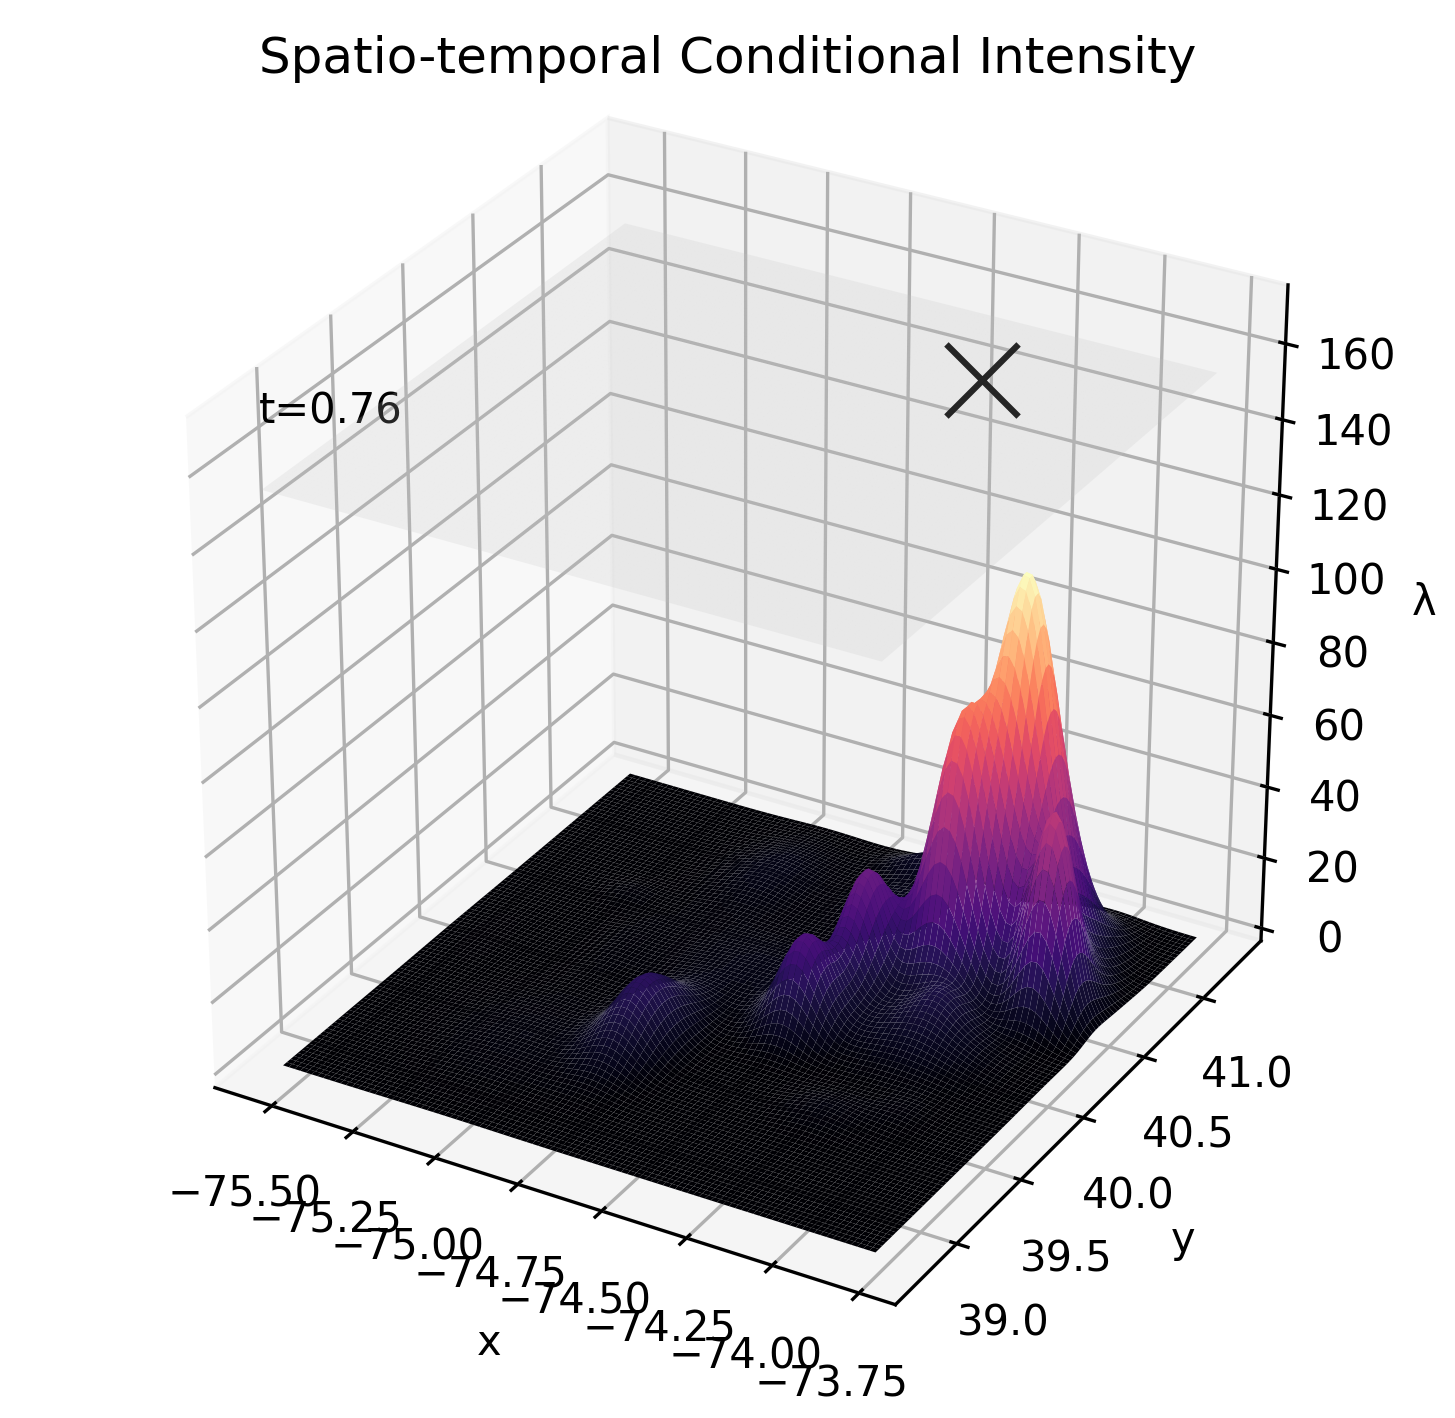

In [ ]:
scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
lambs, x_range, y_range, t_range, his_s, his_t = calc_lamb(model, test_loader, config, device, scales, biases, total_time=7.0, round_time=False)
plot_lambst_static(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=10, 
                   scaler=None, fps=12, fn=f'../video/{dataset}.mp4')

In [ ]:
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/{dataset}_{i}.mod', map_location=torch.device('cpu')))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-0.1150 ± 0.0109
2.4583 ± 0.0008


## Earthquakes JP

In [9]:
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, 
                   lr=0.0003, momentum=0.9, epochs=5, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-3, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='sigmoid', sample=True, decoder_n_layer=3)

In [10]:
dataset = 'earthquakes_jp'
npzf = np.load(f'../data/processed/{dataset}.npz', allow_pickle=True)

In [11]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)
valset   = SlidingWindowWrapper(npzf['val'],   normalized=True, min=trainset.min, max=trainset.max)
testset  = SlidingWindowWrapper(npzf['test'],  normalized=True, min=trainset.min, max=trainset.max)

In [12]:
train_loader = DataLoader(trainset, batch_size=config.batch, shuffle=True)
val_loader   = DataLoader(valset,   batch_size=config.batch, shuffle=False)
test_loader  = DataLoader(testset,  batch_size=config.batch, shuffle=False)

In [13]:
scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
print(scales)
print(biases)

[25.266296  23.938      5.8930182]
[1.22291e+02 2.20010e+01 6.36574e-06]


In [ ]:
from model import DeepSTPP
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/{dataset}_0.mod')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:30:19,013 INFO In epochs 0 | total loss: 0.495398 | Space: 0.990779 | Time: 1.926483


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:30:29,998 INFO In epochs 1 | total loss: 0.246062 | Space: 1.375424 | Time: 1.962644


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:30:41,004 INFO In epochs 2 | total loss: 0.162909 | Space: 1.509208 | Time: 1.977621


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:30:51,964 INFO In epochs 3 | total loss: 0.121318 | Space: 1.577935 | Time: 1.986393


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:31:02,856 INFO In epochs 4 | total loss: 0.096358 | Space: 1.619507 | Time: 1.992185


Evaluate


2021-12-05 21:31:03,166 INFO Val Loss -0.003064 | Space: 1.676017 | Time: 1.887994


training done!


Intensity time range : 30.0


  0%|          | 0/200 [00:00<?, ?it/s]

Inferred cmax: 0.02844509482383728


  0%|          | 0/202 [00:00<?, ?it/s]

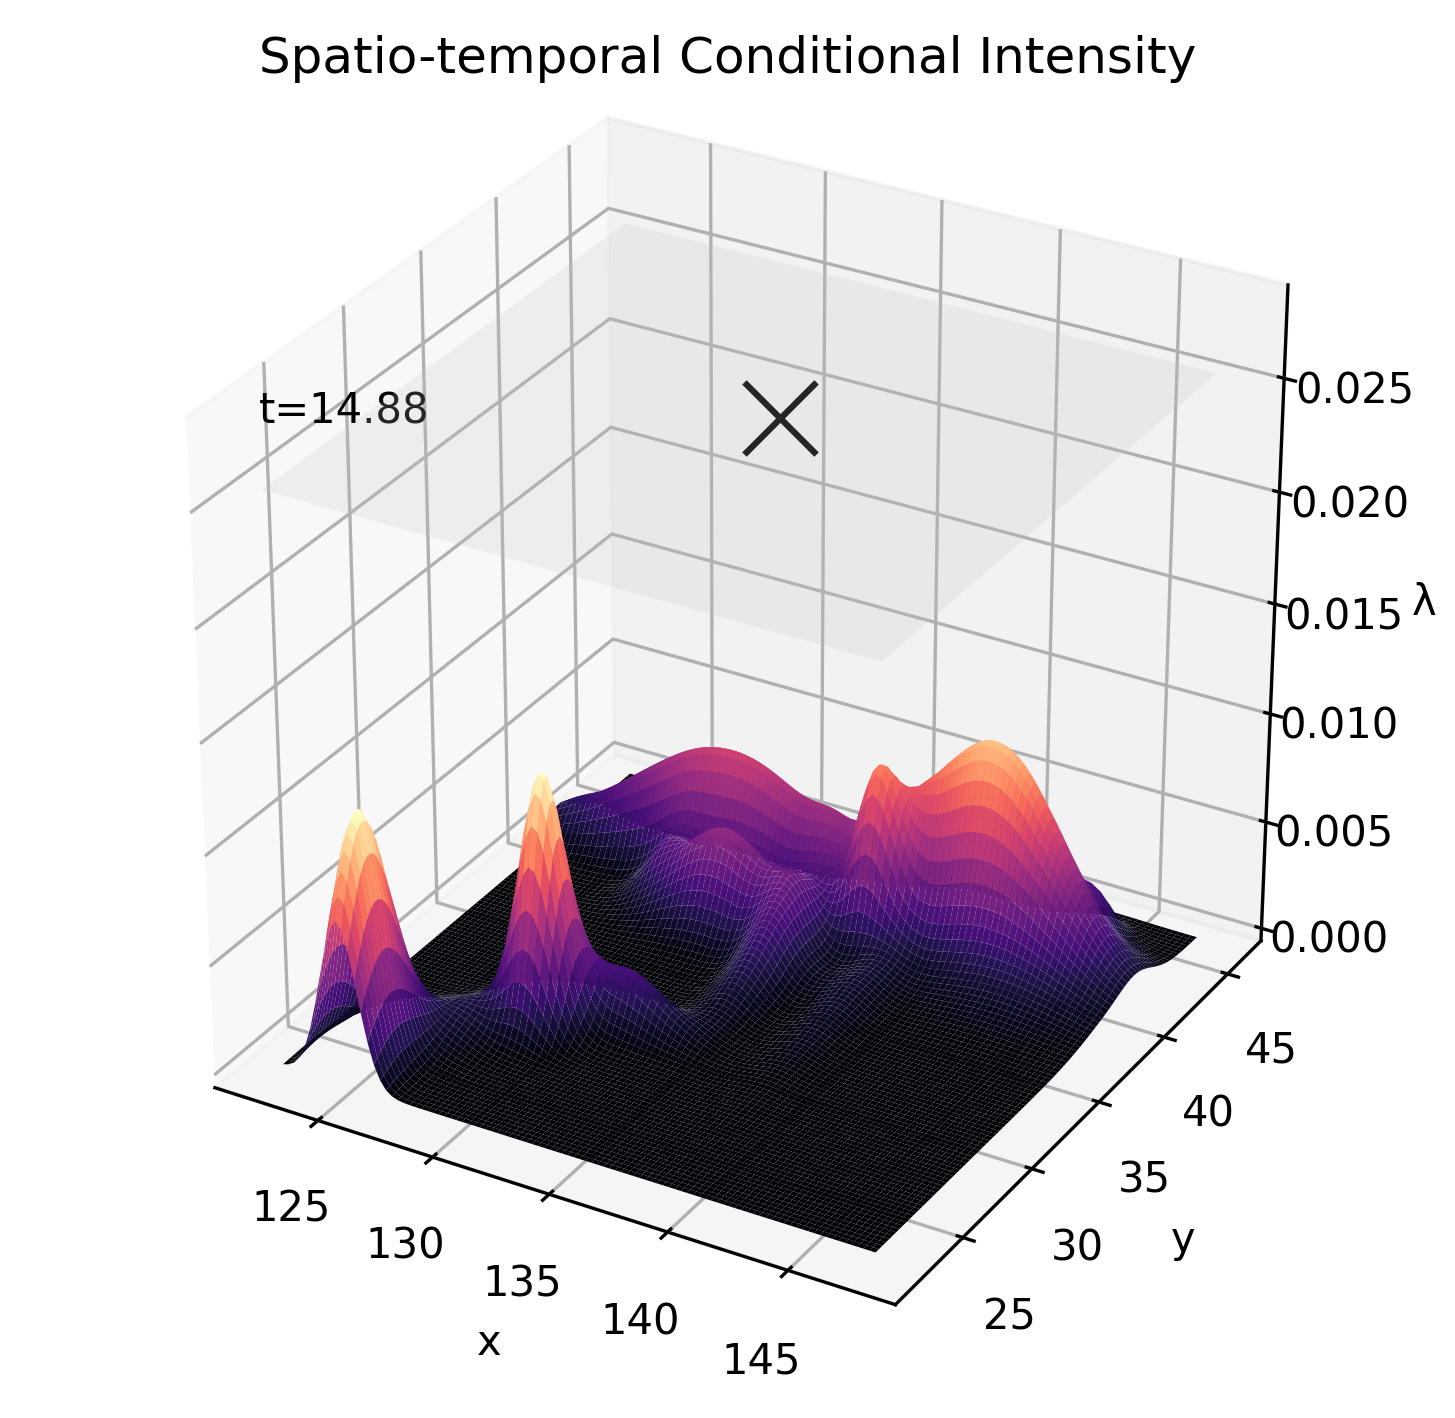

In [ ]:
from model import calc_lamb
lambs, x_range, y_range, t_range, his_s, his_t = calc_lamb(model, test_loader, config, device, scales, biases, total_time=30.0, round_time=False)
plot_lambst_static(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=2, 
                   scaler=None, fps=12, fn=f'../video/{dataset}.mp4')

In [ ]:
from model import DeepSTPP
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/{dataset}_1.mod')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:41:25,856 INFO In epochs 0 | total loss: 0.487937 | Space: 0.898457 | Time: 1.921107


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:41:36,874 INFO In epochs 1 | total loss: 0.242365 | Space: 1.304125 | Time: 1.959146


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:41:48,080 INFO In epochs 2 | total loss: 0.160459 | Space: 1.449316 | Time: 1.975526


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:41:59,064 INFO In epochs 3 | total loss: 0.119487 | Space: 1.525955 | Time: 1.984674


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:42:10,099 INFO In epochs 4 | total loss: 0.094898 | Space: 1.574785 | Time: 1.990692
2021-12-05 21:42:10,302 INFO Val Loss -0.003065 | Space: 1.673457 | Time: 1.888227


Evaluate
training done!


In [ ]:
from model import DeepSTPP
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'../models/{dataset}_2.mod')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:42:22,041 INFO In epochs 0 | total loss: 0.520391 | Space: 0.898284 | Time: 1.920479


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:42:33,042 INFO In epochs 1 | total loss: 0.258578 | Space: 1.292781 | Time: 1.956804


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:42:44,227 INFO In epochs 2 | total loss: 0.171271 | Space: 1.428810 | Time: 1.972689


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:42:55,202 INFO In epochs 3 | total loss: 0.127601 | Space: 1.501588 | Time: 1.982206


  0%|          | 0/416 [00:00<?, ?it/s]

2021-12-05 21:43:06,286 INFO In epochs 4 | total loss: 0.101392 | Space: 1.548805 | Time: 1.988844
2021-12-05 21:43:06,485 INFO Val Loss -0.003330 | Space: 1.641249 | Time: 1.887333


Evaluate
training done!


In [14]:
models = []
for i in range(3):
    model = DeepSTPP(config, device)
    model.load_state_dict(torch.load(f'../models/{dataset}_{i}.mod', map_location=torch.device('cpu')))
    models.append(model)

mult_eval(models, 10, dataset, test_loader, config, device, scales)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

-4.4025 ± 0.0128
0.4173 ± 0.0014
